### Задание
- Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров
    - У вас есть несколько ресторанов в разных частях города и целый штат курьеров. 
    - Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. 
    - Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

- Наши data scientist-ы придумали новый алгоритм:
    - который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. 
    - То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

- Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. 
    - Часть курьеров использует старый алгоритм без опции "по пути"
    - Другая часть видят в своем приложении эту опцию и могут ее выбрать. 

> Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

### Информация о доставке заказов

| Колонка            | Описание                                       |
|--------------------|------------------------------------------------|
| order_id           | Идентификатор заказа                           |
| delivery_time      | Время доставки в минутах                       |
| district           | Район доставки                                 |
| experiment_group   | Экспериментальная группа                       |

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg #лучше показывает

data = pd.read_csv('F:\\карпов\\6 СТАТИСТИКА\\4 Сравнение средних\\4 experiment_lesson_4.csv')
sns.set(rc={'figure.figsize': (16,6),'figure.dpi': (75)},style='darkgrid')

# сводная таблица
lst = []
for name in data.columns:
    nu = len(data[name].unique())
    nisnan = data[name].isnull().sum()
    values_sample = data[name].unique()[:min(nu,10)].tolist()
    lst.append([name,nu,nisnan, values_sample])
    
pd.DataFrame(lst,columns=['column','nunique','nnull','values'])

,column,nunique,nnull,values
0,order_id,20196,0,"[3159, 10426, 9155, 10699, 10061, 5535, 5793, ..."
1,delivery_time,72,0,"[44.0, 51.0, 46.0, 34.0, 43.0, 38.0, 36.0, 57...."
2,district,3,0,"[Purlieus, Central, Suburb]"
3,experiment_group,2,0,"[control, test]"


### 1 Задание:

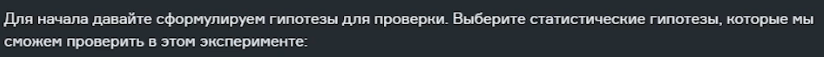

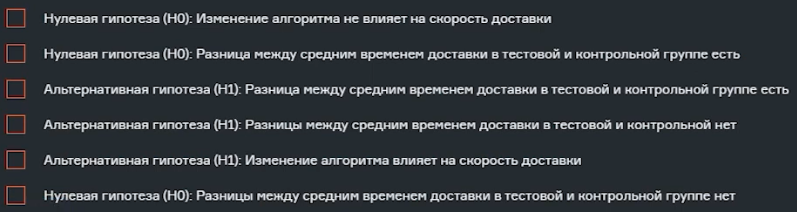

- Нулевая гипотеза (H0): Разница между средним временем доставки в тестовой и контрольной группе нет
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

### 2 Задание:
Сопоставьте графики распределения и эксперементальные группы(что из них тест, что контроль)

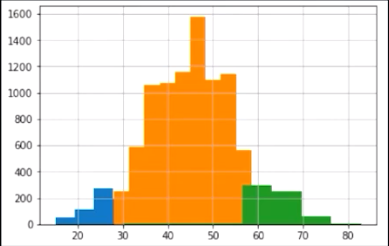
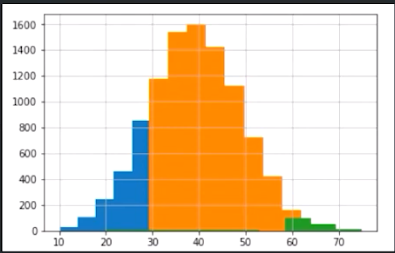

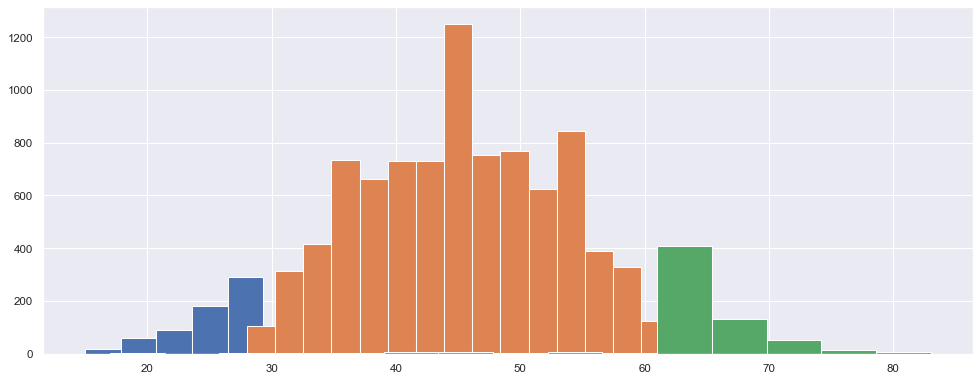

In [26]:
# не мой вариант:
data.query('experiment_group == "control"').groupby('district').delivery_time.hist(bins=15);

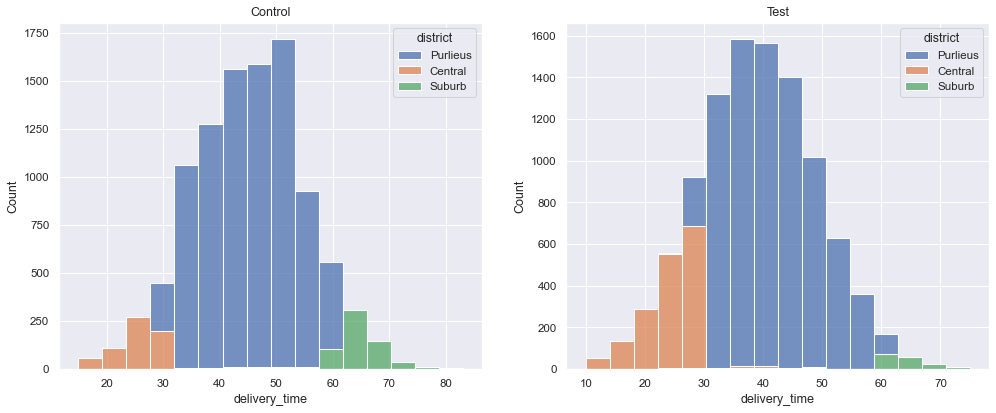

In [6]:
# мой вариант:
fig, axes = plt.subplots(nrows=1, ncols=2)
sns.histplot(data=data.query('experiment_group == "control"'), x = 'delivery_time', hue = 'district',ax=axes[0],multiple="stack",bins=16)
sns.histplot(data=data.query('experiment_group == "test"'),    x = 'delivery_time', hue = 'district',ax=axes[1],multiple="stack",bins=16)

axes[0].set_title('Control')
axes[1].set_title('Test');

### 3 Задание:

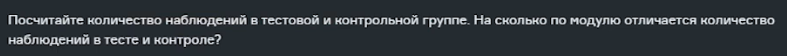

In [7]:
np.abs(data.query('experiment_group ==  "test"')['order_id'].count() - data.query('experiment_group ==  "control"')['order_id'].count())

12

### 4 Задание:

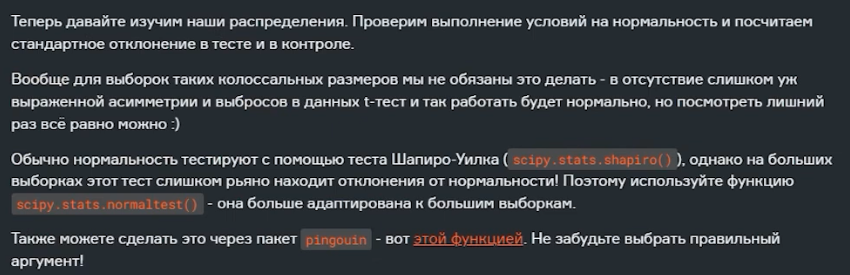

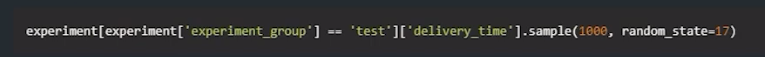

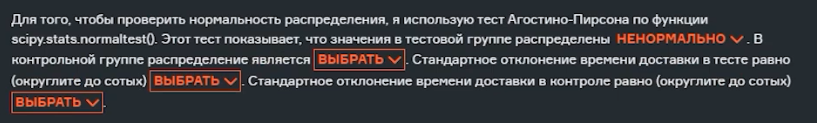

In [34]:
# стандартное отклонение
data.groupby('experiment_group').delivery_time.std().round(2)

experiment_group
control    9.99
test       9.88
Name: delivery_time, dtype: float64

In [53]:
from scipy.stats import normaltest,shapiro, mannwhitneyu
normaltest(data.query('experiment_group ==  "test"')['delivery_time'])

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [36]:
normaltest(data.query('experiment_group ==  "control"')['delivery_time'])

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

использование библиотеки pingouin

In [38]:
# смотрим нормальность по Шапиро(маленькие выборки) < 5000 значений
pg.normality(data=data.sample(1000,random_state=42),dv='delivery_time', group='experiment_group').reset_index()

,experiment_group,W,pval,normal
0,test,0.997476,0.668673,True
1,control,0.994018,0.042220,False


In [30]:
pg.normality(data=data,dv='delivery_time', group='experiment_group',method='normaltest').reset_index()

,experiment_group,W,pval,normal
0,control,0.253498,0.880955,True
1,test,7.024157,0.029835,False


Результаты теста нормальности в данном случае дают нам информацию о том, насколько данные распределены нормально. 
- В данном случае, у p-value, который является мерой того, насколько сильно данные соответствуют нормальному распределению.
- Для теста нормальности есть стандартный уровень значимости, обычно выбираемый на уровне 0.05. Если p-value меньше выбранного уровня значимости, то мы можем отклонить нулевую гипотезу о том, что данные распределены нормально.

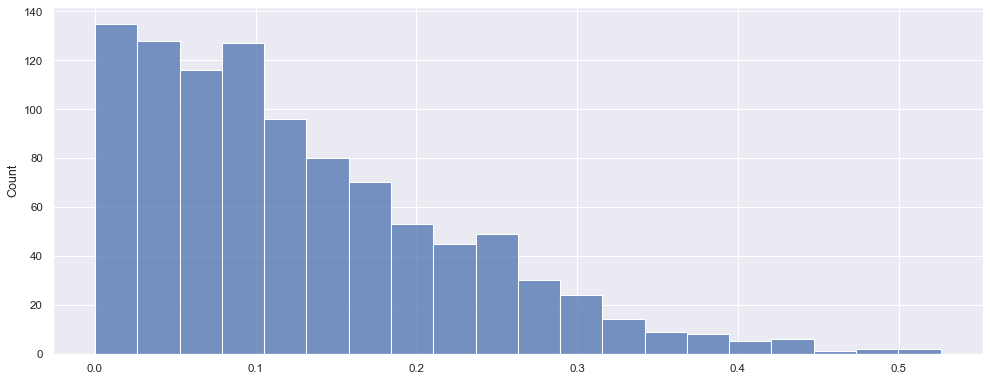

In [40]:
# метод чтобы понять как часто встречается значение p value для разных выборок

# сэмплирование не лучший метод
pvals = []
# сделаем сэмплирование 1000 раз и посмотрим как будут распределяться pvalue
for _ in range(1000):
    res = shapiro(data.query('experiment_group ==  "test"').delivery_time.sample(1000))
    pvals.append(res.pvalue)
sns.histplot(x=pvals);

In [42]:
# завышенная вероятность ошибки 1 рода 25% (распределение не норм)
np.sum(np.array(pvals) < 0.05) / len(pvals)

0.252

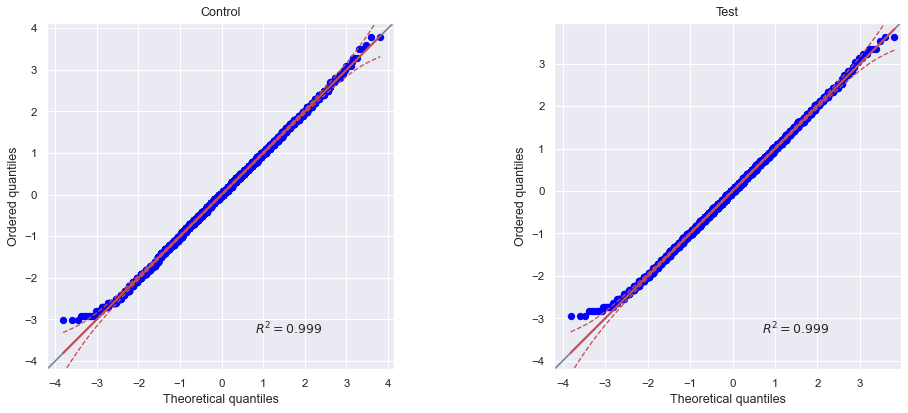

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pg.qqplot(data.query('experiment_group ==  "control"').delivery_time,ax=axes[0])
pg.qqplot(data.query('experiment_group ==  "test"').delivery_time,ax=axes[1])

axes[0].set_title('Control')
axes[1].set_title('Test');

### 5 Задание:
Пришло время сравнить средние в тесте и контроле. Внимание: здесь уже не нужно пользоваться методом sample() - он нам нужен был только для теста Шапиро-Уилка, остальные тесты надо проводить на полных данных.

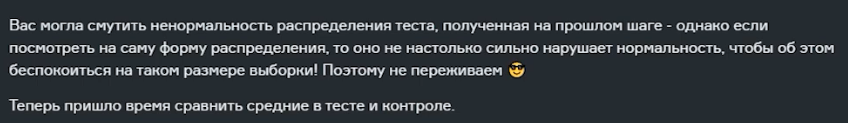

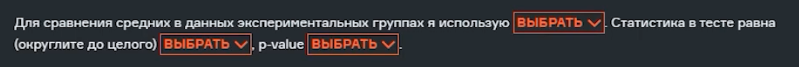

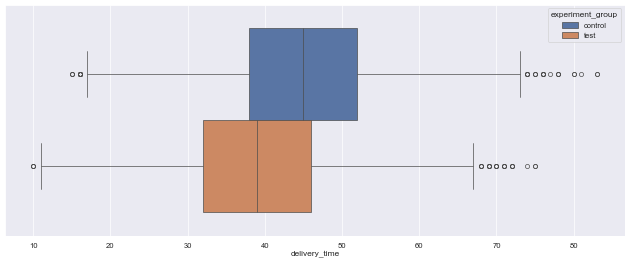

In [11]:
plt.figure(dpi=50)
sns.boxplot(data=data,x='delivery_time',hue = 'experiment_group');

In [62]:
from scipy.stats import ttest_ind

control_data = data.query('experiment_group == "control"')['delivery_time']#.sample(1000,random_state=42)
test_data =    data.query('experiment_group == "test"')['delivery_time']#.sample(1000,random_state=42)

t_stat, p_value = ttest_ind(control_data, test_data)
print(f"P-value: {p_value}")
print(f"T-stat: {t_stat}")

P-value: 0.0
T-stat: 43.03582663183714


In [50]:
# через пингвин
pg.ttest(x = control_data, y = test_data)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,12.953526,1998,two-sided,6.574320e-37,"[4.85, 6.58]",0.579299,3.053e+33,1.0


P value может быть равен '0' при большой выборке, то есть чем больше выборка и если существуют различия тем меньше p value

другие тесты:

In [54]:
# попробуем для сравнения Mанна-Уитни
mannwhitneyu(x= control_data, y = test_data)

MannwhitneyuResult(statistic=659014.5, pvalue=7.078050816783601e-35)

In [56]:
# пингвин
pg.mwu(x = control_data, y = test_data)

,U-val,alternative,p-val,RBC,CLES
MWU,659014.5,two-sided,7.078051e-35,-0.318029,0.659014


In [57]:
# Yuen t-test(вырезает выбросы) усеченные средние
ttest_ind(a= control_data, b = test_data, trim=.2)

TtestResult(statistic=12.40989092784503, pvalue=2.3503319990619547e-33, df=1198.0)

In [59]:
# permutation t-test (перестановочный тест)
ttest_ind(a= control_data, b = test_data, permutations=1000)

TtestResult(statistic=12.95352629865135, pvalue=0.000999000999000999, df=nan)

### 6 Задание:
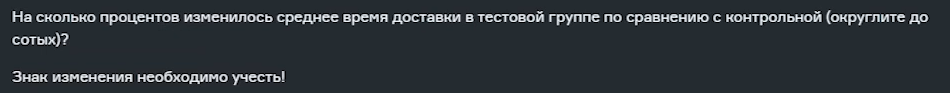

In [71]:
mean_control = data.query('experiment_group ==  "control"')['delivery_time'].mean().round(2) 
mean_test = data.query('experiment_group ==  "test"')['delivery_time'].mean().round(2)
round((1 - (mean_test / mean_control)) * 100,2)

13.36

### 7 Задание:
Что в итоге? Катим?

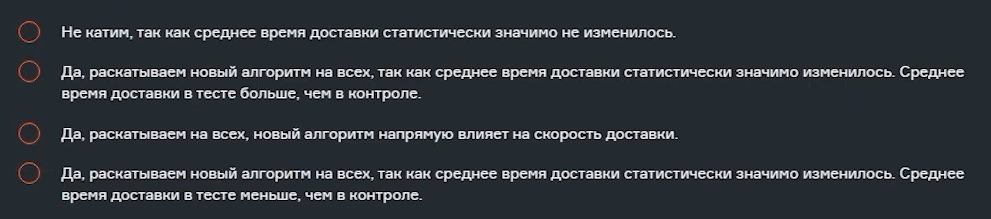

(4) Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в котроле